Are certain actors targeting specific regions more frequently, and does this correlate with civilian targeting or time of year?

In [2]:
# 1.1 Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# 1.2 Set up paths
INPUT_FILE = "../data/raw/missiles-acled-18-october-2023.csv" 
OUTPUT_DIR = "../data/processed"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Optional for better visuals
sns.set(style="whitegrid")


In [18]:
# 2.1 Load dataset
df = pd.read_csv(INPUT_FILE, delimiter=';')

# 2.2 Convert date and extract time components
df['event_date'] = pd.to_datetime(df['event_date'], errors='coerce')
df['month'] = df['event_date'].dt.month
df['day'] = df['event_date'].dt.day
df['day_of_week'] = df['event_date'].dt.day_name()

# 2.3 Fill NaNs if necessary
df['civ_targeting'] = df['civilian_targeting'].fillna("Unknown")
df['actor1'] = df['actor1'].fillna("Unknown")
df['admin1'] = df['admin1'].fillna("Unknown")

# 2.4 Export preprocessed data
df.to_csv(f"{OUTPUT_DIR}/04/preprocessed_data.csv", index=False)

df.head()
# 3.1 Create a summary of the data
summary = df.describe(include='all')
print(summary)
print(df.head())


       event_id_cnty                     event_date          year  \
count          19126                          19126  19126.000000   
unique         15400                            NaN           NaN   
top         LBN25386                            NaN           NaN   
freq               2                            NaN           NaN   
mean             NaN  2024-07-17 21:55:41.754679552   2023.932605   
min              NaN            2023-10-08 00:00:00   2023.000000   
25%              NaN            2024-03-30 00:00:00   2024.000000   
50%              NaN            2024-09-16 00:00:00   2024.000000   
75%              NaN            2024-10-24 00:00:00   2024.000000   
max              NaN            2025-04-25 00:00:00   2025.000000   
std              NaN                            NaN      0.382911   

        time_precision       disorder_type                  event_type  \
count     19126.000000               19126                       19126   
unique             NaN 

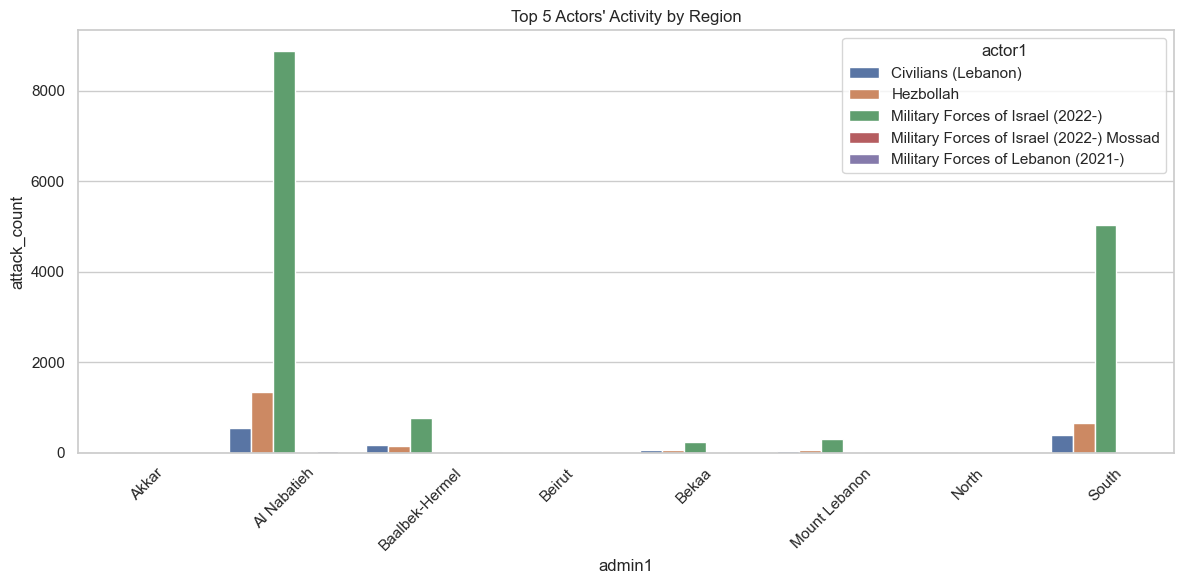

In [6]:
# 3.1 Group by actor and region
actor_region_freq = df.groupby(['actor1', 'admin1']).size().reset_index(name='attack_count')

# 3.2 Plot top actors by region
plt.figure(figsize=(12, 6))
top_actors = actor_region_freq.groupby('actor1')['attack_count'].sum().sort_values(ascending=False).head(5).index
sns.barplot(
    data=actor_region_freq[actor_region_freq['actor1'].isin(top_actors)],
    x='admin1', y='attack_count', hue='actor1'
)
plt.title("Top 5 Actors' Activity by Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04/actor_region_frequency.png")
plt.show()


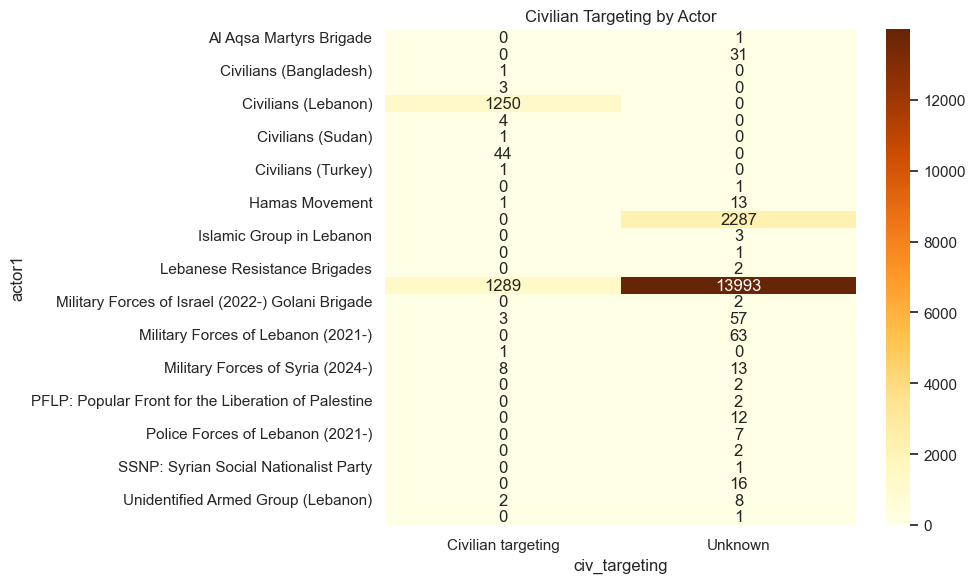

In [8]:
# 4.1 Civilian targeting by actor and region
civ_corr = df.groupby(['actor1', 'admin1', 'civ_targeting']).size().reset_index(name='count')

# 4.2 Pivot for heatmap
pivot_civ = civ_corr.pivot_table(index='actor1', columns='civ_targeting', values='count', aggfunc='sum', fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_civ, annot=True, fmt="d", cmap="YlOrBr")
plt.title("Civilian Targeting by Actor")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04/civilian_targeting_by_actor.png")
plt.show()


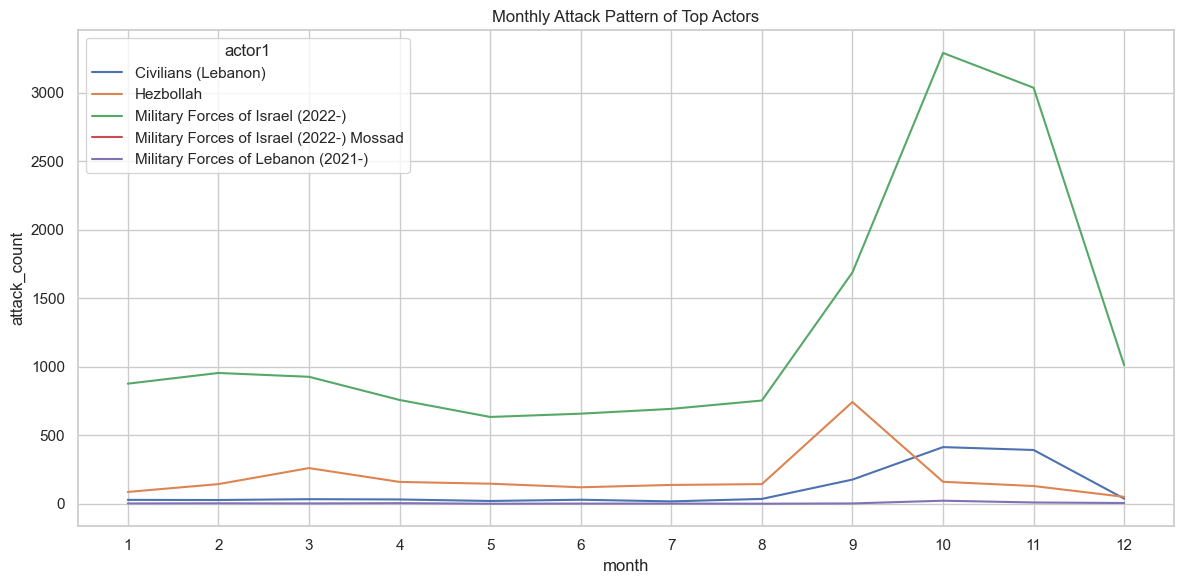

In [ ]:
# 5.1 Group by actor and month
monthly_attacks = df.groupby(['actor1', 'month']).size().reset_index(name='attack_count')

# 5.2 Plot seasonal pattern
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_attacks[monthly_attacks['actor1'].isin(top_actors)], x='month', y='attack_count', hue='actor1')
plt.title("Monthly Attack Pattern of Top Actors")
plt.xticks(range(1, 13))
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04/monthly_attack_pattern.png")
plt.show()


In [10]:
df_model = df[[
    'actor1',
    'admin1',      # region
    'latitude',
    'longitude',
    'month',
    'year',
    'civilian_targeting'
]].copy()

# Flag civilian targeting
df_model['civ_target_flag'] = df_model['civilian_targeting'].notna().astype(int)

# Encode actor1 and region (admin1)
df_model_encoded = pd.get_dummies(df_model[['actor1', 'admin1', 'month']], drop_first=True)

# Add geo + civilian target
df_model_encoded[['latitude', 'longitude', 'civ_target_flag']] = df_model[['latitude', 'longitude', 'civ_target_flag']]


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model_encoded)

kmeans = KMeans(n_clusters=4, random_state=42)
df_model['cluster'] = kmeans.fit_predict(X_scaled)


In [12]:
# Actor per cluster
actor_by_cluster = df_model.groupby(['cluster', 'actor1']).size().unstack().fillna(0)

# Civilian targeting rate per cluster
civ_target_rate = df_model.groupby('cluster')['civ_target_flag'].mean()

# Region per cluster
region_by_cluster = df_model.groupby(['cluster', 'admin1']).size().unstack().fillna(0)

# Monthly distribution
month_by_cluster = df_model.groupby(['cluster', 'month']).size().unstack().fillna(0)


In [14]:
import folium

m = folium.Map(location=[df_model['latitude'].mean(), df_model['longitude'].mean()], zoom_start=9)

for _, row in df_model.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        color=f'#{row["cluster"]+1}22AAEE',
        fill=True,
        fill_opacity=0.7,
        popup=f"Actor: {row['actor1']} | CivTarget: {row['civ_target_flag']}"
    ).add_to(m)

m.save("../data/processed/04/clustered_map.html")


In [15]:
summary_text = """
Cluster Analysis Summary Report
===============================

1. Number of clusters identified: {num_clusters}

2. Cluster-wise Actor Dominance:
{actor_summary}

3. Cluster-wise Region Dominance:
{region_summary}

4. Civilian Targeting Rate per Cluster:
{civ_target_summary}

5. Time of Year Patterns per Cluster:
{month_summary}

Interpretation:
---------------
- Certain clusters are dominated by specific actors such as {dominant_actors}.
- These actors tend to operate more frequently in regions such as {dominant_regions}.
- Civilian targeting rates vary among clusters, with clusters {high_civ_target_clusters} having notably higher rates.
- Time-of-year analysis shows clusters with peak activity during months {peak_months}.

"""

# Fill placeholders with actual summaries (use your analysis variables)
num_clusters = df_model['cluster'].nunique()

# Example: summarize actor distribution per cluster (top 3 actors per cluster)
actor_summary = actor_by_cluster.apply(lambda x: x.nlargest(3).to_dict(), axis=1).to_string()

# Example: summarize region distribution per cluster (top 3 regions per cluster)
region_summary = region_by_cluster.apply(lambda x: x.nlargest(3).to_dict(), axis=1).to_string()

# Civilian targeting rate (rounded)
civ_target_summary = civ_target_rate.round(3).to_string()

# Month summary (top 3 months per cluster)
month_summary = month_by_cluster.apply(lambda x: x.nlargest(3).to_dict(), axis=1).to_string()

# Extract dominant actors and regions globally for interpretation
dominant_actors = ', '.join(df_model['actor1'].value_counts().head(3).index)
dominant_regions = ', '.join(df_model['admin1'].value_counts().head(3).index)

# High civilian target clusters (with > average civilian target rate)
average_civ_target_rate = civ_target_rate.mean()
high_civ_target_clusters = ', '.join([str(c) for c, val in civ_target_rate.items() if val > average_civ_target_rate])

# Peak months globally (top months overall)
peak_months = ', '.join(df_model['month'].value_counts().head(3).index.astype(str))

# Format the summary
summary_str = summary_text.format(
    num_clusters=num_clusters,
    actor_summary=actor_summary,
    region_summary=region_summary,
    civ_target_summary=civ_target_summary,
    month_summary=month_summary,
    dominant_actors=dominant_actors,
    dominant_regions=dominant_regions,
    high_civ_target_clusters=high_civ_target_clusters,
    peak_months=peak_months
)

# Write to file in processed folder
with open("../data/processed/04/cluster_summary.txt", "w") as f:
    f.write(summary_str)


In [3]:
import folium

# Use your DataFrame (ensure it has 'latitude', 'longitude', 'cluster', 'actor1', and 'civ_target_flag' columns)
# Replace `df_model` with the actual DataFrame name if different
m = folium.Map(location=[df_model['latitude'].mean(), df_model['longitude'].mean()], zoom_start=8)

# Define a color palette for clusters (just in case the hex fails)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 
          'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white',
          'pink', 'lightblue', 'lightgreen', 'gray', 'black']

# Add circle markers
for _, row in df_model.iterrows():
    cluster_id = int(row['cluster']) if 'cluster' in row and pd.notna(row['cluster']) else 0
    color = colors[cluster_id % len(colors)]  # cycle through colors safely

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=folium.Popup(f"""
            <strong>Actor:</strong> {row.get('actor1', 'N/A')}<br>
            <strong>Civ Target:</strong> {row.get('civ_target_flag', 'N/A')}
        """, max_width=250)
    ).add_to(m)

# Display the map in notebook
m


NameError: name 'df_model' is not defined